# Discriminator

In [1]:
import torch
import os
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.utils import make_grid


class Discriminator(nn.Module):
  def __init__(self,infeatures):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(in_features=infeatures,out_features=128),
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=128,out_features=64),
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=64,out_features=1),
        nn.Sigmoid(),
    )

  def forward(self,img):
    ori = self.network(img)
    return(ori)


# Generator

In [2]:
class Generator(nn.Module):
  def __init__(self,laten_dim,img_dim):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(in_features=laten_dim,out_features=64),
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=64,out_features=128),
        nn.LeakyReLU(0.2),
        nn.Linear(128,img_dim), #28x28x1 --- 784
        nn.Tanh(),
    )

  def forward(self,noise):
    return(self.network(noise))


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 32
img_dim = 28*28*1
num_epoch = 10
batch_size = 32

discrimi = Discriminator(img_dim).to(device)
generat = Generator(z_dim,img_dim).to(device)

transforms = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize with mean and std
])


# DataSet Loader

In [4]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(discrimi.parameters(), lr=lr)
opt_gen = optim.Adam(generat.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4195119.97it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 125476.82it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1187459.33it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4926436.20it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

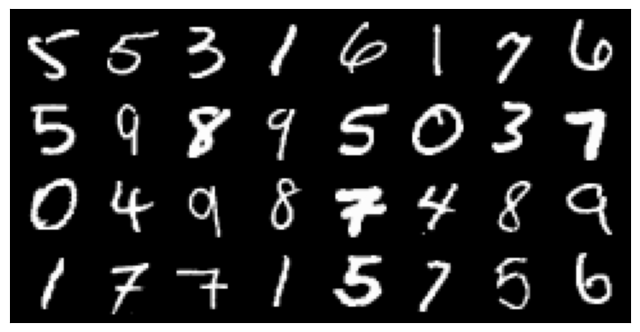

In [7]:
show_batch(loader)

In [8]:
sample_dir = 'Generated'
os.makedirs(sample_dir, exist_ok=True)

In [9]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generat(latent_tensors).reshape(-1, 1, 28, 28)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [10]:
for epoch in range(num_epoch):
  for batch_idx, (real, _) in enumerate(loader):

    #discriminator
    noise = torch.randn(batch_size,z_dim).to(device)
    # print("img",real.shape)
    flat_img = real.view(batch_size,-1).to(device)
    # print("flattened img",flat_img.shape)
    real_disc = discrimi(flat_img).view(-1)
    gen_img = generat(noise)
    fake_disc = discrimi(gen_img.detach()).view(-1)


    #loss function max log(D(real))+log(1-D(G(fake)))
    criterion = nn.BCEWithLogitsLoss()
    loss_dis_fake = criterion(real_disc,torch.ones_like(real_disc))
    loss_disc_real = criterion(fake_disc,torch.zeros_like(fake_disc))
    dis_loss = (loss_dis_fake + loss_disc_real)/2
    discrimi.zero_grad()
    dis_loss.backward()
    opt_disc.step()
    #Generator loss is min log(1-D(G(fake))) and max log(D(G(fake)))
    gen_fake = discrimi(gen_img)
    gen_loss = criterion(gen_fake,torch.ones_like(gen_fake))
    generat.zero_grad()
    gen_loss.backward()
    opt_gen.step()



    if batch_idx == 0:
        print(
            f"Epoch [{epoch}/{num_epoch}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {dis_loss:.4f}, loss G: {gen_loss:.4f}"
        )

        with torch.no_grad():
            fake = generat(noise).reshape(-1, 1, 28, 28)
            data = real.reshape(-1, 1, 28, 28)
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(data, normalize=True)

            writer_fake.add_image(
                "Mnist Fake Images", img_grid_fake, global_step=step
            )
            writer_real.add_image(
                "Mnist Real Images", img_grid_real, global_step=step
            )
            step += 1
        save_samples(epoch+1, noise, show=False)


Epoch [0/10] Batch 0/1875                   Loss D: 0.7188, loss G: 0.4681
Saving generated-images-0001.png
Epoch [1/10] Batch 0/1875                   Loss D: 0.5032, loss G: 0.6931
Saving generated-images-0002.png
Epoch [2/10] Batch 0/1875                   Loss D: 0.6516, loss G: 0.5151
Saving generated-images-0003.png
Epoch [3/10] Batch 0/1875                   Loss D: 0.5693, loss G: 0.6746
Saving generated-images-0004.png
Epoch [4/10] Batch 0/1875                   Loss D: 0.5997, loss G: 0.6909
Saving generated-images-0005.png
Epoch [5/10] Batch 0/1875                   Loss D: 0.6931, loss G: 0.6931
Saving generated-images-0006.png
Epoch [6/10] Batch 0/1875                   Loss D: 0.6931, loss G: 0.6931
Saving generated-images-0007.png
Epoch [7/10] Batch 0/1875                   Loss D: 0.6931, loss G: 0.6931
Saving generated-images-0008.png
Epoch [8/10] Batch 0/1875                   Loss D: 0.6931, loss G: 0.6931
Saving generated-images-0009.png
Epoch [9/10] Batch 0/1875   

In [11]:
from IPython.display import Image

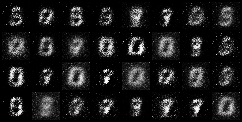

In [12]:
Image('./Generated/generated-images-0010.png')